# Exemplo de Agente Reflexivo com LangGraph e LLM

Neste exemplo, implementamos um Agente Reflexivo utilizando LangGraph e um modelo de linguagem (LLM) acessado via API.

O objetivo do agente é gerar código Python automaticamente a partir de uma descrição de tarefa, executar testes automatizados e, caso ocorram erros, refletir sobre a falha e tentar corrigir o código, repetindo esse ciclo até atingir o sucesso ou um número máximo de tentativas.

## Objetivo Didático

Demonstrar na prática:

- Como estruturar um agente baseado em estado
- Como modelar um fluxo de execução usando grafos de estados
- Como implementar um ciclo de:
-- Geração
-- Execução
-- Avaliação
-- Reflexão
- Como integrar LLMs com validação automática via pytest

### Instalando bibliotecas utilizadas nessa prática

In [1]:
!python -m pip install langgraph langchain==1.1.0 openai pytest python-dotenv


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Configuração do modelo LLM
Lembre-se de adicionar corretamente a chave no arquivo `.env`.

In [2]:
import subprocess
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

base_url = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com/20231130/actions/v1"  # ou sua URL
api_key = os.getenv("OCI_API_KEY")

client = OpenAI(
    base_url=base_url,
    api_key=api_key
)

MODEL = "xai.grok-4-fast-non-reasoning"  # ou modelo compatível


c:\Users\Amanda Machado\AppData\Local\Programs\Python\Python314\Lib\site-packages\langchain_core\_api\deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


### Criação da estrutura de estado do langgraph

In [21]:
class AgentState(TypedDict):
    task: str
    solution_code: Optional[str]
    test_code: Optional[str]
    error: Optional[str]
    attempts: int

MAX_ATTEMPTS = 3

### Primeiro Nó - Geração de código

In [74]:
def generate_code(state: AgentState):
    prompt = f"""
    Gere:
    1) O código Python da solução
    2) Um arquivo de teste pytest completo para validar a solução

    Separe claramente como:

    # solution.py
    <codigo>

    # test_solution.py
    <codigo>

    IMPORTANTE:
    - Nunca adicione caracteres especiais ou marcação de inicio de código
    - Explicações devem ser apenas em comentários
    - Gere o código final executável 
    
    Tarefa:
    {state['task']}
    """

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )

    content = response.choices[0].message.content

    # separação simples
    solution_part = content.split("# test_solution.py")[0]
    test_part = content.split("# test_solution.py")[1]

    return {
        "solution_code": solution_part.replace("# solution.py", "").strip(),
        "test_code": test_part.strip(),
        "attempts": state["attempts"] + 1
    }

### Segundo Nó - Execução de testes

In [75]:
import sys
import subprocess


def execute_code(state: AgentState):
    solution = state["solution_code"]
    test = state["test_code"]

    with open("solution.py", "w", encoding="utf-8") as f:
        f.write(solution)

    with open("test_solution.py", "w", encoding="utf-8") as f:
        f.write(test)

    result = subprocess.run(
        [sys.executable, "-m", "pytest", "-q"],
        capture_output=True,
        text=True
    )

    print(result.stdout)
    print(result.stderr)

    if result.returncode == 0:
        return {"error": None}
    else:
        return {"error": result.stdout + result.stderr}

### Terceiro Nó - Observação dos testes

In [87]:
def reflect(state: AgentState):
    prompt = f"""
    A tarefa original é:
    {state['task']}

    A solução atual é:
    {state['solution_code']}

    O teste atual é:
    {state['test_code']}

    O erro retornado pelo pytest foi:
    {state['error']}

    Corrija o que for necessário.

    IMPORTANTE:
    - Retorne apenas código Python.
    - Não use markdown.
    - Não use explicações.
    - Não use emojis.
    - Não use listas.
    - Retorne exatamente no formato:

    # solution.py
    <codigo>

    # test_solution.py
    <codigo>
    """

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}]
    )

    content = response.choices[0].message.content

    try:
        solution_part = content.split("# test_solution.py")[0]
        test_part = content.split("# test_solution.py")[1]

        solution_code = solution_part.replace("# solution.py", "").strip()
        test_code = test_part.strip()

    except Exception:
        return {
            "error": "Modelo retornou formato inválido durante reflexão.",
            "attempts": state["attempts"] + 1
        }

    return {
        "solution_code": solution_code,
        "test_code": test_code,
        "attempts": state["attempts"] + 1
    }

### Lógica de decisão 

In [81]:

def should_continue(state: AgentState):
    if state["error"] is None:
        return END
    if state["attempts"] >= MAX_ATTEMPTS:
        return END
    return "reflect"

### Construção do Grafo
Adição dos nós e arrestas

In [83]:

graph = StateGraph(AgentState)

graph.add_node("generate", generate_code)
graph.add_node("execute", execute_code)
graph.add_node("reflect", reflect)

graph.set_entry_point("generate")

graph.add_edge("generate", "execute")
graph.add_conditional_edges(
    "execute",
    should_continue,
    {
        "reflect": "reflect",
        END: END
    }
)

graph.add_edge("reflect", "execute")

app = graph.compile()

### [Opcional] Visualização do grafo criado

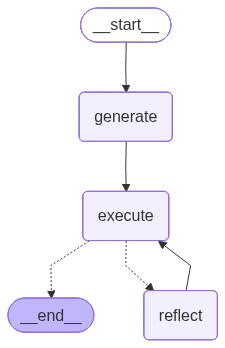

In [84]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Execução

In [85]:

initial_state = {
    "task": "Implemente uma função soma(a, b) que retorna a soma.",
    "solution_code": None,
    "test_code": None,
    "error": None,
    "attempts": 0
}

result = app.invoke(initial_state)
print("Final State:", result)

....F..                                                                  [100%]
================================== FAILURES ===================================
______________________________ test_soma_floats _______________________________

    def test_soma_floats():
        """Testa soma de nÃºmeros de ponto flutuante."""
        assert soma(2.5, 3.7) == 6.2
>       assert soma(-1.2, 4.8) == 3.6
E       assert 3.5999999999999996 == 3.6
E        +  where 3.5999999999999996 = soma(-1.2, 4.8)

test_solution.py:24: AssertionError
=========================== short test summary info ===========================
FAILED test_solution.py::test_soma_floats - assert 3.5999999999999996 == 3.6
1 failed, 6 passed in 0.16s


.......                                                                  [100%]
7 passed in 0.02s


Final State: {'task': 'Implemente uma função soma(a, b) que retorna a soma.', 'solution_code': 'def soma(a, b):\n    """\n    Função que retorna a soma de dois números.\n    \n   

### Impressão separada dos elementos gerados na execução do grafo

In [86]:
print("Tarefa:")
print(result["task"])

print("\nCódigo Gerado:")
print(result["solution_code"])

print("\nErro:")
print(result["error"])

print("\nTentativas:")
print(result["attempts"])

Tarefa:
Implemente uma função soma(a, b) que retorna a soma.

Código Gerado:
def soma(a, b):
    """
    Função que retorna a soma de dois números.
    
    Args:
        a (int ou float): Primeiro número
        b (int ou float): Segundo número
    
    Returns:
        int ou float: Soma de a e b
    """
    return a + b

Erro:
None

Tentativas:
2
